### Environment Setup

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import randint
import time
import random
import torch.utils.data as data
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import cv2
import sys, os

#### Hyper-parameters and Device

In [ ]:
batch_size = 64
num_classes = 3
learning_rate = 0.001
num_epochs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Specify Repositories

In [55]:
root_dir = os.getcwd() + '/data_processing'
image_dir = root_dir + '/all_images/'
train_dir = root_dir + '/train_set_with_label'
test_dir = root_dir + '/test_set_with_label'
val_dir = root_dir + '/val_set_with_label'

In [6]:
len(os.listdir(image_dir))

9029

In [7]:
for file in os.listdir(image_dir):
    assert file.endswith(".jpg")

In [8]:
model_dir = os.getcwd() + '/model_CNN_try2/'

### Dataloader

#### face image dataset

In [9]:
class FaceSet(data.Dataset):
    def __init__(self,folder,transform):
        self.transform=transform
        imgs=[os.path.join(folder,f) for f in os.listdir(folder)]
        self.imgs = imgs
        
    def __getitem__(self,index):
        imgpath=self.imgs[index]
        im=Image.open(imgpath)
        if im.mode == "RGBA":
            r, g, b, a=im.split ()
            im=Image.merge ("RGB", (r, g, b))
        elif im.mode!="RGB":
            im=im.convert ("RGB")
        im=self.transform(im)
        symbol = imgpath.split('/')[-1].split('.')[0].split('_')[-1]
        if symbol == "0":
            label = 0
        elif symbol == "1":
            label = 1
        else:
            label = 2
        return im,label
    
    def __len__(self):
        return len(self.imgs)

#### image transformer

In [10]:
transform_train=transforms.Compose([ 
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
transform_test=transforms.Compose([ 
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

for fn in os.listdir(image_dir):
    im=Image.open(image_dir + fn)
    print(transform_train(im).size())
    break

torch.Size([3, 32, 32])


In [11]:
# define dataset
trainset=FaceSet(train_dir,transform=transform_train)
valset=FaceSet(val_dir,transform=transform_test)
testset=FaceSet(test_dir,transform=transform_test)

In [ ]:
# define dataloader
bs = batch_size
train_loader=torch.utils.data.DataLoader(trainset,batch_size=bs,shuffle=True,num_workers=0)
val_loader=torch.utils.data.DataLoader(valset,batch_size=bs,shuffle=False,num_workers=0)
test_loader=torch.utils.data.DataLoader(testset,batch_size=bs,shuffle=False,num_workers=0)

### Model Architecture

![title](report_images/CNN_architecture.png)

#### model implementation

In [20]:
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

### Model Training

In [51]:
model = cnn()
cost = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
total_step = len(train_loader)

In [52]:
total_step = len(train_loader)

epoch_num = range(num_epochs)
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

for epoch in range(num_epochs):
    
    ### Train
    correct = 0
    total = 0
    running_loss = 0.0
    model.train()
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_acc = correct / total
    train_loss = running_loss / (i+1)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
        
    print ('Train Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
    .format(epoch+1, num_epochs, i+1, total_step, train_loss, train_acc))
    
    ### Evaluation
    correct = 0
    total = 0
    running_loss = 0.0
    model.eval()
    for i, (images, labels) in enumerate(val_loader):  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        
    val_acc = correct / total
    val_loss = running_loss / (i+1)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
        
    print ('Val Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
    .format(epoch+1, num_epochs, i+1, total_step, val_loss, val_acc))

Train Epoch [1/10], Step [113/113], Loss: 0.7562, Accuracy: 0.6531
Val Epoch [1/10], Step [15/113], Loss: 0.7032, Accuracy: 0.6891
Train Epoch [2/10], Step [113/113], Loss: 0.5927, Accuracy: 0.7377
Val Epoch [2/10], Step [15/113], Loss: 0.5533, Accuracy: 0.7424
Train Epoch [3/10], Step [113/113], Loss: 0.5358, Accuracy: 0.7676
Val Epoch [3/10], Step [15/113], Loss: 0.5499, Accuracy: 0.7554
Train Epoch [4/10], Step [113/113], Loss: 0.4861, Accuracy: 0.7876
Val Epoch [4/10], Step [15/113], Loss: 0.5149, Accuracy: 0.7620
Train Epoch [5/10], Step [113/113], Loss: 0.4441, Accuracy: 0.8112
Val Epoch [5/10], Step [15/113], Loss: 0.4847, Accuracy: 0.8000
Train Epoch [6/10], Step [113/113], Loss: 0.4094, Accuracy: 0.8371
Val Epoch [6/10], Step [15/113], Loss: 0.4771, Accuracy: 0.8109
Train Epoch [7/10], Step [113/113], Loss: 0.3712, Accuracy: 0.8474
Val Epoch [7/10], Step [15/113], Loss: 0.4840, Accuracy: 0.8120
Train Epoch [8/10], Step [113/113], Loss: 0.3145, Accuracy: 0.8711
Val Epoch [8/10]

### Testing

In [48]:
### Test
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test set: {} %'.format(100 * correct / total))

Accuracy of the network on the test set: 83.04347826086956 %


### Loss and Acc Visualization

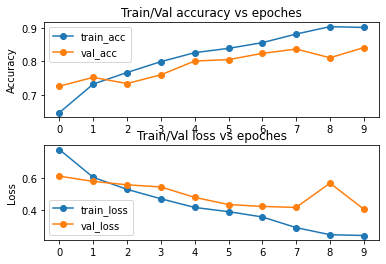

In [50]:
from matplotlib.pyplot import MultipleLocator
import matplotlib.pyplot as plt

plt.subplot(2, 1, 1)
plt.plot(epoch_num, train_acc_list, 'o-', label='train_acc')
plt.plot(epoch_num, val_acc_list, 'o-', label='val_acc')
plt.legend()
plt.title('Train/Val accuracy vs epoches')
x = MultipleLocator(1)
ax = plt.gca()
ax.xaxis.set_major_locator(x)
plt.ylabel('Accuracy')
plt.subplots_adjust(wspace=0, hspace=0.3)
plt.subplot(2, 1, 2)
plt.plot(epoch_num, train_loss_list, 'o-', label='train_loss')
plt.plot(epoch_num, val_loss_list, 'o-', label='val_loss')
plt.legend()
plt.title('Train/Val loss vs epoches')
x = MultipleLocator(1)
ax = plt.gca()
ax.xaxis.set_major_locator(x)
plt.ylabel('Loss')
plt.show()

### Discussion

We choose CNN as one of our models in solving facial mask detection because it usually serves as a natural and popular choice for image recognition tasks. With literature review and experiments in model training, we summarize the properties of CNN as follows:

#### Advantages

- Image feature capturing: CNN can accurately capture local patterns on images, thus providing insightful and interpretable feature banks to drive image recognition tasks.

- Parameter sharing: CNN model supports parameter sharing which greatly decrease reduce the burden of weight updating, which also speeds up the learning procedure.

- Parallel computation: Infra-wise, CNN computation can be easily parallelized (with GPU, for example) to reduce training durations. This is especially useful when we are dealing with bulk media data (e.g. image, audio, video).

#### Disadvantages

- The decision made by CNN models largely depend on individual filters. However, over-emphasizing on individual features might give rise to neglegance of the bigger picture. As a result, predictions of CNN can be obviously off because two totally irrelevant objects may happen to share some features.

### Reference

Y. Lecun, L. Bottou, Y. Bengio and P. Haffner, "Gradient-based learning applied to document recognition," in Proceedings of the IEEE, vol. 86, no. 11, pp. 2278-2324, Nov. 1998, doi: 10.1109/5.726791.

Puja Gupta, Varsha Sharma, Sunita Varma,
A novel algorithm for mask detection and recognizing actions of human,
Expert Systems with Applications,
Volume 198,
2022,
116823,
ISSN 0957-4174,
https://doi.org/10.1016/j.eswa.2022.116823.